In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
import matplotlib.dates as mdates
import shutil
import sys
from configobj import ConfigObj
import json
from distutils.util import strtobool
import h5py
# from calfews_src.model_cy cimport Model
from calfews_src.inputter_cy import Inputter
from calfews_src.scenario import Scenario
from calfews_src.util import *
from calfews_src.plotter import *
from calfews_src.visualizer import Visualizer
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import make_scorer, r2_score
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold

from matplotlib import pyplot

import joblib
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# os.chdir("C:/Users/danli/OneDrive - University of North Carolina at Chapel Hill/github/CALFEWS")
os.getcwd()

'c:\\Users\\danli\\OneDrive - University of North Carolina at Chapel Hill\\github\\CALFEWS'

In [83]:
# from pathlib import Path
# folder_path = Path("calfews_src/data/MGHMM_synthetic/")
# csv_files = folder_path.glob("DailyQ_s0.csv")

# for csv_file in csv_files:

#     df = pd.read_csv(csv_file)
#     df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
#     df.set_index('Date', inplace=True)
#     df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
#     df.to_csv(csv_file)

#     print(f"Processed {csv_file}")

In [5]:

def filter_dates(file_path, output_folder):
    df = pd.read_csv(file_path)
    
    
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    
    # Define the original and new date ranges
    original_start_date = pd.Timestamp('1997-01-01')
    original_end_date = pd.Timestamp('1999-12-31')
    new_start_date = pd.Timestamp('2024-01-01')
    new_end_date = pd.Timestamp('2026-12-31')

    
    date_shift = new_start_date - original_start_date
    
    # Shift the dates
    df['Date'] = df['Date'] + date_shift
    
    # Extract year, month, day from the new Date
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    
    # Drop the temporary Date column
    df.drop(columns=['Date'], inplace=True)
    
    # Save the modified DataFrame to a new CSV file
    output_file_path = os.path.join(output_folder, os.path.basename(file_path))
    df.to_csv(output_file_path, index=False)

# Define folder paths
input_folder_path = 'calfews_src/data/MGHMM_synthetic/'
output_folder_path = 'calfews_src/data/MGHMM_synthetic/'

# Create output folder if it doesn't exist
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# Process all files in the folder
filenames = [f'DailyQ_s{i}.csv' for i in range(100)]

for filename in filenames:
    file_path = os.path.join(input_folder_path, filename)
    filter_dates(file_path, output_folder_path)

In [ ]:
# cut the synthetic data to water years to run CALFEWS

def filter_dates(file_path):
    df = pd.read_csv(file_path)
    
    df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
    start_date = pd.Timestamp('2024-10-01')
    end_date = pd.Timestamp('2026-9-30')
    
    filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
    filtered_df = filtered_df.drop(columns=['Date'])
        # Drop the last row
    # if not filtered_df.empty:
    #     filtered_df = filtered_df.iloc[:-1]
    filtered_df.to_csv(file_path, index=False)

folder_path = 'calfews_src/data/MGHMM_synthetic/'
filenames = [f'DailyQ_s{i}.csv' for i in range(100)]

for filename in filenames:
    file_path = os.path.join(folder_path, filename)
    filter_dates(file_path)

In [37]:
#Load data (NQH2O water price index)
NQH2O_hist = pd.read_excel('calfews_src/data/price_index/NQH2O_20180801-20240819.xlsx')
NQH2O_hist.rename({'Trade Date': 'Date', 'Index Value': 'NQH2O'}, axis=1, inplace=True)
NQH2O_hist = NQH2O_hist[['Date', 'NQH2O']]

NQH2O_pre = pd.read_csv('calfews_src/data/price_index/AdditionalData_NQH2O.csv', encoding='ISO-8859-1')
NQH2O_pre = NQH2O_pre[['Date', 'NQH2O']]
NQH2O_pre['Date'] = pd.to_datetime(NQH2O_pre['Date'])

combined_df = pd.concat([NQH2O_hist, NQH2O_pre]).sort_values(by='Date')
combined_df.reset_index(drop=True, inplace=True)

combined_df['Date'] = pd.to_datetime(combined_df['Date'])
combined_df['6_Month_Forward_Avg'] = None

# Function to calculate the 6-month forward average
def calculate_6_month_forward_avg(current_date, df):
    end_date = current_date + pd.DateOffset(months=6)
    
    mask = (df['Date'] >= current_date) & (df['Date'] <= end_date)
    relevant_prices = df.loc[mask, 'NQH2O']

    if len(relevant_prices) > 0:
        return relevant_prices.mean()
    else:
        return None

combined_df['6_Month_Forward_Avg'] = combined_df['Date'].apply(lambda x: calculate_6_month_forward_avg(x, combined_df))
# combined_df

In [38]:
#around 100 columns do not exisit in the synthetic data, remove those features in the validation data that will be used to train the model
reference_file = 'results/1/results.hdf5'
output_folder = "results/short_test/"
output_file = output_folder + 'results.hdf5'
fig_folder = output_folder + 'figs/'

reference_df = get_results_sensitivity_number_outside_model(reference_file, '')
datDaily = get_results_sensitivity_number_outside_model(output_file, '')

reference_columns = set(reference_df.columns)
datDaily_columns = set(datDaily.columns)

columns_to_remove = datDaily_columns - reference_columns
datDaily.drop(columns=columns_to_remove, inplace=True)

print(f"Number of columns removed: {len(columns_to_remove)}")
print("Removed columns in datDaily:")
print(columns_to_remove)

Number of columns removed: 87
Removed columns in datDaily:
{'tehachapi_tableA_recharged', 'tehachapi_recover_banked', 'northkern_tableA_flood', 'castaic_SOC_exchanged_SW', 'arvin_recover_banked', 'losthills_tableA_turnback', 'southbay_exchange_recharged', 'tehachapi_pumping', 'coachella_SOC_friant1_flood', 'delano_RRB_recharged', 'xvc_CAA_flow', 'southbay_tableA_paper', 'metropolitan_SOC_recover_banked', 'rosedale_exchanged_SW', 'arvin_kaweah_flood_irrigation', 'castaic_SOC_friant1_flood', 'exchange_turnback', 'pixley_tule_flood_irrigation', 'buenavista_tableA_flood_irrigation', 'northkern_tableA_flood_irrigation', 'kerndelta_tableA_paper', 'bakersfield_tableA_flood', 'terra_kings_flood_irrigation', 'tulare_friant2_turnback', 'southbay_exchange_turnback', 'kerntulare_ARV_recharged', 'arvin_tableA_flood_irrigation', 'lindmore_friant2_recharged', 'coachella_SOC_tableA_paper', 'metropolitan_SOC_pumping', 'bakersfield_pumping', 'ID4_friant1_flood_irrigation', 'kerndelta_kern_paper', 'semit

In [39]:
# load short-test output (1996-2024) 
# rolling average of the model output

window_size = '180D'  # Compute the past 6-month rolling average 
average_values_df = datDaily.rolling(window=window_size, center=False).mean()  #make sure center is False so it is indeed a trailing window
merged_df = pd.merge(average_values_df, combined_df, left_on=average_values_df.index, right_on='Date')

In [40]:
def remove_duplicate_columns(df): # this is necessary for aligning features between the short-test output and 2 year synthetic run (there are duplicate columns in the short-test output)
    duplicated_columns = df.columns[df.columns.duplicated()]
    
    print(f"Duplicate columns found: {duplicated_columns.tolist()}")
    columns_to_drop = []
    
    # Iterate through the duplicated columns and mark all but the first occurrence for dropping
    for col in duplicated_columns:
       
        col_indices = [i for i, x in enumerate(df.columns) if x == col]
        columns_to_drop.extend(col_indices[1:])
    df = df.drop(df.columns[columns_to_drop], axis=1)
    
    return df

In [41]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df.fillna(merged_df.mean(), inplace=True)

X = merged_df.drop(columns=['Date', 'NQH2O', '6_Month_Forward_Avg'])
y = merged_df['6_Month_Forward_Avg']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
X = X.drop(columns=non_numeric_columns)
X = remove_duplicate_columns(X)

corr_matrix = X.corr().abs()
# Select upper triangle of the correlation matrix to keep the first occurrence of highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]   # corr threshold = 0.7
print(f"Number of columns to drop: {len(to_drop)}")
X = X.drop(columns=to_drop)

feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.pkl') # save feature columns for prediction later

X_train_val, X_test, y_train_val, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']
X.shape

Duplicate columns found: ['socal_tableA_delivery', 'socal_tableA_recharged', 'socal_tableA_projected', 'socal_cvpdelta_dynamic_recharge_cap', 'socal_exchange_dynamic_recharge_cap', 'socal_cvc_dynamic_recharge_cap', 'socal_friant1_dynamic_recharge_cap', 'socal_friant2_dynamic_recharge_cap', 'socal_kaweah_dynamic_recharge_cap', 'socal_tule_dynamic_recharge_cap', 'socal_kern_dynamic_recharge_cap', 'socal_kings_dynamic_recharge_cap', 'socal_IVR_recharged', 'socal_RRB_recharged', 'socal_dynamic_recovery_cap', 'socal_irr_demand', 'socal_tot_demand', 'socal_kern_flood_irrigation', 'socal_tableA_paper', 'socal_exchanged_SW', 'socal_tableA_dynamic_recharge_cap', 'socal_pumping', 'socal_tableA_turnback', 'socal_tableA_carryover', 'centralcoast_tableA_projected', 'centralcoast_cvpdelta_dynamic_recharge_cap', 'centralcoast_exchange_dynamic_recharge_cap', 'centralcoast_cvc_dynamic_recharge_cap', 'centralcoast_friant1_dynamic_recharge_cap', 'centralcoast_friant2_dynamic_recharge_cap', 'centralcoast_

(606, 504)

In [ ]:
# random correlation matrix
# np.random.seed(42)
# num_samples = 100
# num_features = 10
# random_data = np.random.rand(num_samples, num_features)

# columns = [f'Feature_{i+1}' for i in range(num_features)]
# df_random = pd.DataFrame(random_data, columns=columns)

# corr_matrix = df_random.corr().abs()

# plt.figure(figsize=(10, 8))
# sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
# plt.title('Correlation Matrix for Random Parameters')
# plt.show()

## visualization

Linear Regression Train R^2: 0.9591472463155254
Linear Regression Test R^2: 0.9386330363448722
Polynomial Regression Train R^2: 0.9983685284306564
Polynomial Regression Test R^2: 0.9951887006123037
Random Forest Train R^2: 0.9973415071399506
Random Forest Test R^2: 0.983154956169364


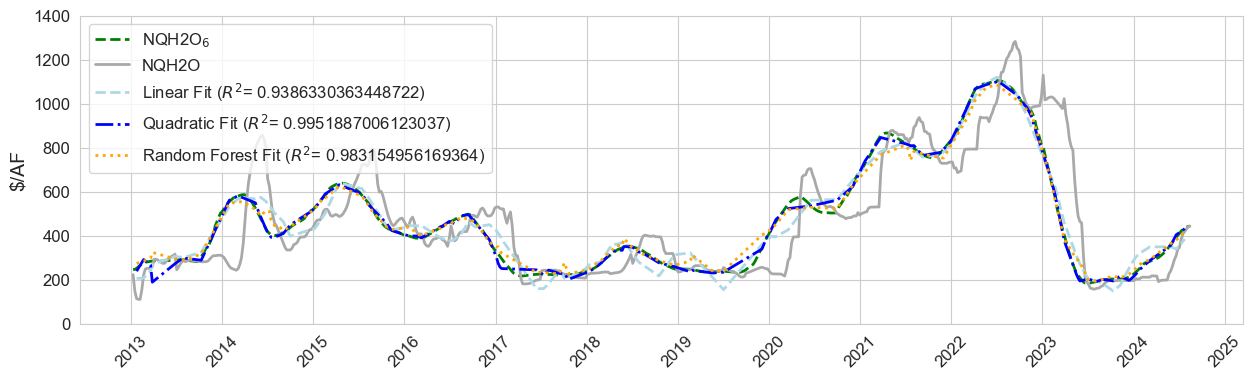

In [10]:
# this cell is not being used for prediction, but for visualization purposes/method exploration

scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # keep 95% of variance
X_train_val_selected = pca.fit_transform(X_train_val, y_train_val)
X_test_selected = pca.transform(X_test)
scorer = make_scorer(r2_score)


linear_reg = LinearRegression()
y_pred_linear_train = cross_val_predict(linear_reg, X_train_val_selected, y_train_val, cv=3)
linear_reg.fit(X_train_val_selected, y_train_val)
y_pred_linear_test = linear_reg.predict(X_test_selected)


polynomial_reg_pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('linear', LinearRegression())
])
polynomial_reg_grid = {'poly__degree': [2]}
polynomial_reg_cv = GridSearchCV(estimator=polynomial_reg_pipeline, param_grid=polynomial_reg_grid, scoring=scorer, cv=3)
polynomial_reg_cv.fit(X_train_val_selected, y_train_val)
y_pred_poly_train = polynomial_reg_cv.predict(X_train_val_selected)
y_pred_poly_test = polynomial_reg_cv.predict(X_test_selected)

random_forest = RandomForestRegressor(random_state=42)
random_forest_grid = {
    # 'n_estimators': [100, 200], 'max_depth': [None, 10, 20]
    'n_estimators': [100, 50, 200],  # Number of trees in the forest
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'max_depth': [10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [2, 4] }
random_forest_cv = GridSearchCV(estimator=random_forest, param_grid=random_forest_grid, scoring=scorer, cv=3)
random_forest_cv.fit(X_train_val_selected, y_train_val)
y_pred_rf_train = random_forest_cv.predict(X_train_val_selected)
y_pred_rf_test = random_forest_cv.predict(X_test_selected)

# Best model from Linear Regression
# best_linear_reg = linear_reg_cv.best_estimator_
best_polynomial_reg = polynomial_reg_cv.best_estimator_
best_random_forest = random_forest_cv.best_estimator_

linear_reg_train_r2 = r2_score(y_train_val, y_pred_linear_train)
polynomial_reg_train_r2 = r2_score(y_train_val, best_polynomial_reg.predict(X_train_val_selected))
random_forest_train_r2 = r2_score(y_train_val, best_random_forest.predict(X_train_val_selected))

linear_reg_test_r2 = r2_score(y_test, y_pred_linear_test)
polynomial_reg_test_r2 = r2_score(y_test, best_polynomial_reg.predict(X_test_selected))
random_forest_test_r2 = r2_score(y_test, best_random_forest.predict(X_test_selected))

print(f"Linear Regression Train R^2: {linear_reg_train_r2}")
print(f"Linear Regression Test R^2: {linear_reg_test_r2}")

print(f"Polynomial Regression Train R^2: {polynomial_reg_train_r2}")
print(f"Polynomial Regression Test R^2: {polynomial_reg_test_r2}")

print(f"Random Forest Train R^2: {random_forest_train_r2}")
print(f"Random Forest Test R^2: {random_forest_test_r2}")

# predictions and actuals to sort by date
test_results = pd.DataFrame({
    'date': test_date, 
    'actual': y_test,
    'NQH2O': test_nqh2o,
    'predicted_linear': y_pred_linear_test,
    'predicted_quadratic': y_pred_poly_test,
    'predicted_rf': y_pred_rf_test
})

# Sort the DataFrame by date
test_results = test_results.sort_values(by='date')

# 9. Plot results
plt.figure(figsize=(15, 4))

# Plotting the data with thicker lines
plt.plot(merged_df['Date'], merged_df['6_Month_Forward_Avg'], label='NQH2O$_{6}$', linestyle='--', color='green', linewidth=2)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_linear'], label=f'Linear Fit ($R^{{2}}$= {linear_reg_test_r2})', linestyle='--', color='lightblue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_quadratic'], label=f'Quadratic Fit ($R^{{2}}$= {polynomial_reg_test_r2})', linestyle='-.',  color='blue', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_rf'], label=f'Random Forest Fit ($R^{{2}}$= {random_forest_test_r2})', linestyle=':', color='orange', linewidth=2)

# Labels, Title, and Formatting
plt.ylabel('$/AF', fontsize=14)
plt.ylim(0, 1400)
# plt.title('Actual and Predicted 6-Month Forward Averages (based on CALFEWS Output)', fontsize=16)

# Format the x-axis to only show the year
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')

plt.show()

# joblib.dump(scaler, 'scaler.pkl')
# joblib.dump(pca, 'pca.pkl')
# joblib.dump(linear_reg, 'linear_reg.pkl')

## method selction

In [ ]:

# pd.set_option('display.max_rows', None)

# Step 1: Fit the Lasso model on the full dataset to determine the top features --> prediction results not good, as Lasso tend to relies heavily on a few features
# Lasso is feature dominant, so it is not a good model to use for prediction
# full_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
# full_pipeline.fit(X_train_val, y_train_val)
# y_pred = full_pipeline.predict(X_test)

# pca = PCA(n_components=0.95)  # Retain 95% of the variance
# X_train_val_pca = pca.fit_transform(X_train_val)
# X_test_pca = pca.transform(X_test)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('elasticnet', ElasticNet(ElasticNet(max_iter=10000)))
])

param_grid = {
    'elasticnet__alpha': [1, 5, 10, 20,50.0, 100],
    'elasticnet__l1_ratio': [0.1, 0.4,0.5]  #1 corresponds to pure L1 regularization (Lasso Regression) -->  sparse models
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2')

grid_search.fit(X_train_val, y_train_val)

best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best params: {best_params}')


y_pred = best_pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
print(f'R² score on the test set with optimized ElasticNet: {r2:.2f}')

elasticnet_coef = best_pipeline.named_steps['elasticnet'].coef_

coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Coefficient': elasticnet_coef
})

coefficients['Rank'] = coefficients['Coefficient'].abs().rank(ascending=False)
coefficients.sort_values(by='Rank')

# Step 2: Select the top 20 or 100 features
# top_features = coefficients.head(40)
# top_feature_names = top_features['Feature'].tolist()
# print(top_features)

# # Step 3: Retrain the Lasso model using only the top features
# X_top_20 = X[top_feature_names]

# X_train_val_top_20, X_test_top_20, y_train_val, y_test, train_date, test_date = train_test_split(
#     X_top_20, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42
# )

# # top_20_pipeline = make_pipeline(StandardScaler(), Lasso(alpha=0.1))
# top_20_pipeline = make_pipeline(StandardScaler(), ElasticNetCV(cv=5, l1_ratio=0.5, random_state=42))
# top_20_pipeline.fit(X_train_val_top_20, y_train_val)

# y_pred_top_20 = top_20_pipeline.predict(X_test_top_20)

# r2_top_20 = r2_score(y_test, y_pred_top_20)
# print(f'R² score on the test set with top 20 features: {r2_top_20:.2f}')

# joblib.dump(top_20_pipeline, 'lasso_pipeline_top_20.pkl')
# joblib.dump(top_feature_names, 'top_features.pkl')
# joblib.dump(full_pipeline, 'elasticnet_pipeline_optimized.pkl')
# joblib.dump(pca, 'pca_model.pkl')
joblib.dump(best_pipeline, 'elasticnet_pipeline_optimized.pkl')
# joblib.dump(pca, 'pca_model.pkl')


Best params: {'elasticnet__alpha': 1, 'elasticnet__l1_ratio': 0.5}
R² score on the test set with optimized ElasticNet: 0.87


['elasticnet_pipeline_optimized.pkl']

In [42]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=5)),  # Adjust n_components based on your dataset
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 50, 200],  # Number of trees in the forest
    'rf__max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'rf__max_depth': [10, 20],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [2, 4]  # Minimum number of samples required to be at a leaf node
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2')
grid_search.fit(X_train_val, y_train_val)

best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best params: {best_params}')
y_pred_test = best_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
print(f'R² score on the test set with optimized RandomForestRegressor: {r2_test:.2f}')

feature_importances = best_pipeline.named_steps['rf'].feature_importances_

coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})

coefficients['Rank'] = coefficients['Importance'].rank(ascending=False)
coefficients.sort_values(by='Rank')


# Save the best pipeline
joblib.dump(best_pipeline, 'random_forest_pipeline_with_pca.pkl')

Best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
R² score on the test set with optimized RandomForestRegressor: 0.99


['random_forest_pipeline_with_pca.pkl']

In [43]:
coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})
coefficients = coefficients.sort_values(by='Importance', ascending=False)
coefficients['Rank'] = range(1, len(coefficients) + 1)
# print(coefficients.head(10))
# print(coefficients.head(10)[['features']])
# feature_importances

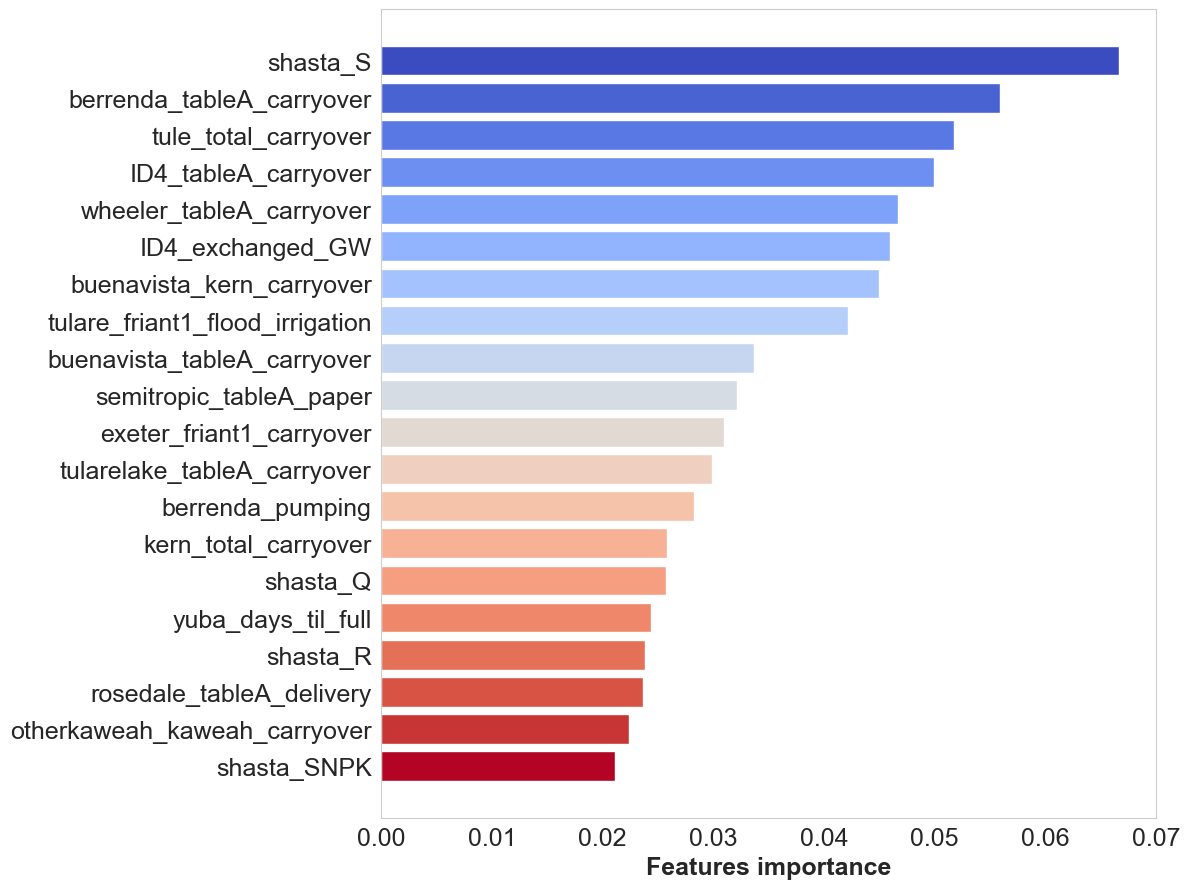

In [65]:
import matplotlib.cm as cm

# Change color template and add conference-friendly styles
plt.figure(figsize=(12, 9))
colors = cm.coolwarm(np.linspace(0, 1, 20))  # Use different shades from the 'viridis' colormap
plt.barh(coefficients.head(20)['features'], coefficients.head(20)['Importance'], color=colors)
plt.xlabel('Features importance', fontsize=18, fontweight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
# plt.ylabel('Features', fontsize=14, fontweight='bold')
# plt.title('Feature Importance derived from RF', fontsize=16, fontweight='bold')
plt.grid(False)
plt.gca().invert_yaxis()  # To have the highest rank at the top
plt.tight_layout()
plt.show()

In [15]:
def ensure_columns_match(df, reference_columns, fill_value='mean', fallback_value= 0):
    for col in reference_columns:
        if col not in df.columns:
            df[col] = np.nan
    
    # Ensure columns match the reference list
    df = df[reference_columns]
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        mean_value = df[col].mean() if not df[col].isna().all() else fallback_value
        df[col].fillna(mean_value, inplace=True)

    df[numeric_cols] = df[numeric_cols].clip(lower=np.finfo(np.float64).min, upper=np.finfo(np.float64).max, axis=1)
   
    return df

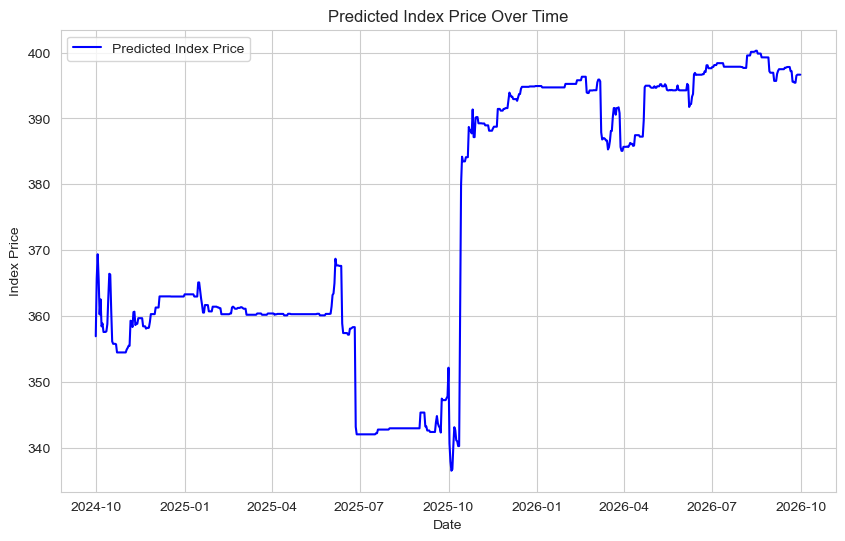

In [16]:
elasticnet_pipeline = joblib.load('random_forest_pipeline_with_pca.pkl')
# pca = joblib.load('pca_model.pkl')

output_folder = "results/"
scenario_folder = os.path.join(output_folder, str(1))
output_file = os.path.join(scenario_folder, 'results.hdf5')


hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

window_size = '180D'
X = hydro_data.rolling(window=window_size, center=False).mean()
X['water_year'] = X.index.map(lambda x: x.year if x.month < 10 else x.year + 1)

X_top_20 = ensure_columns_match(X, feature_columns)
predicted_index_price = elasticnet_pipeline.predict(X_top_20)


plt.figure(figsize=(10, 6))
plt.plot(X.index, predicted_index_price, label='Predicted Index Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.title('Predicted Index Price Over Time')
plt.legend()
plt.show()

In [17]:
# lasso_pipeline = joblib.load('lasso_pipeline_top_20.pkl')
# top_features = joblib.load('top_features.pkl')
# elasticnet_pipeline = joblib.load('elasticnet_pipeline_optimized.pkl')
random_forest_pipeline_with_pca = joblib.load('random_forest_pipeline_with_pca.pkl')
# pca = joblib.load('pca_model.pkl')

output_folder = 'results/'

plt.figure(figsize=(15, 10))
all_predictions = []
all_indices = []
for scenario_number in range(1, 101):
    scenario_folder = os.path.join(output_folder, str(scenario_number))
    output_file = os.path.join(scenario_folder, 'results.hdf5')
    hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

    # Calculate rolling mean
    window_size = '180D'
    X = hydro_data.rolling(window=window_size, center=False).mean()
    X['water_year'] = X.index.map(lambda x: x.year if x.month < 10 else x.year + 1)

    # Ensure feature columns match
    # X_top_20 = ensure_columns_match(X, top_features)
    # predicted_index_price = lasso_pipeline.predict(X_top_20)
    X_matched = ensure_columns_match(X, feature_columns)
    # X_pca = pca.transform(X_matched)
    predicted_index_price = random_forest_pipeline_with_pca.predict(X_matched)
    
    all_predictions.append(predicted_index_price)
    all_indices.append(X.index)
    

<Figure size 1500x1000 with 0 Axes>

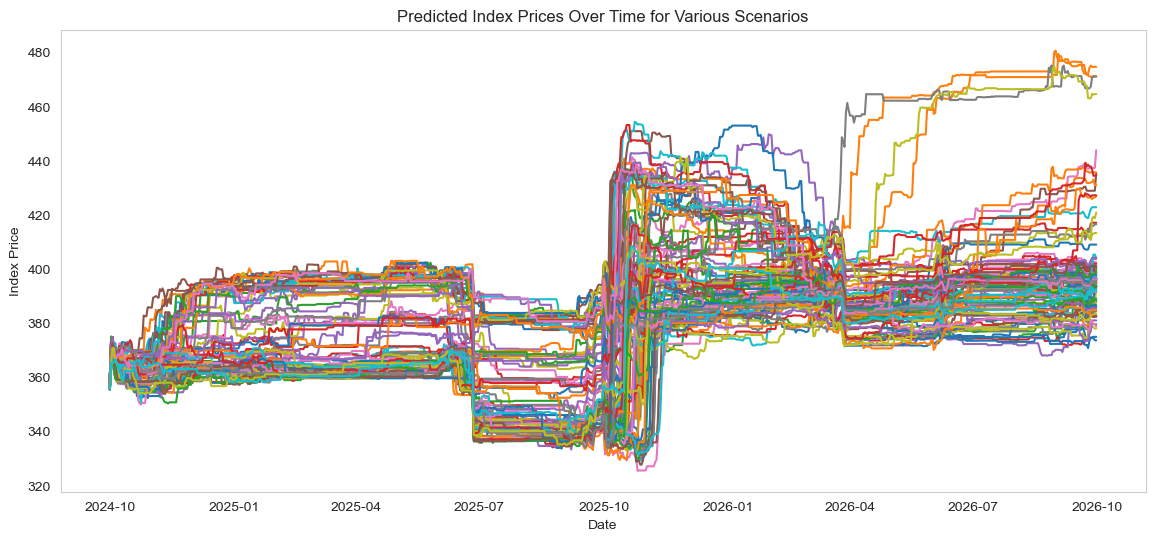

In [20]:
plt.figure(figsize=(14, 6))
for i in range(len(all_predictions)):
    plt.plot(all_indices[i], all_predictions[i], label=f'Scenario {i+1}')

# Finalize the main plot
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.grid(False)
# plt.ylim(-2000, 1000)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
plt.show()

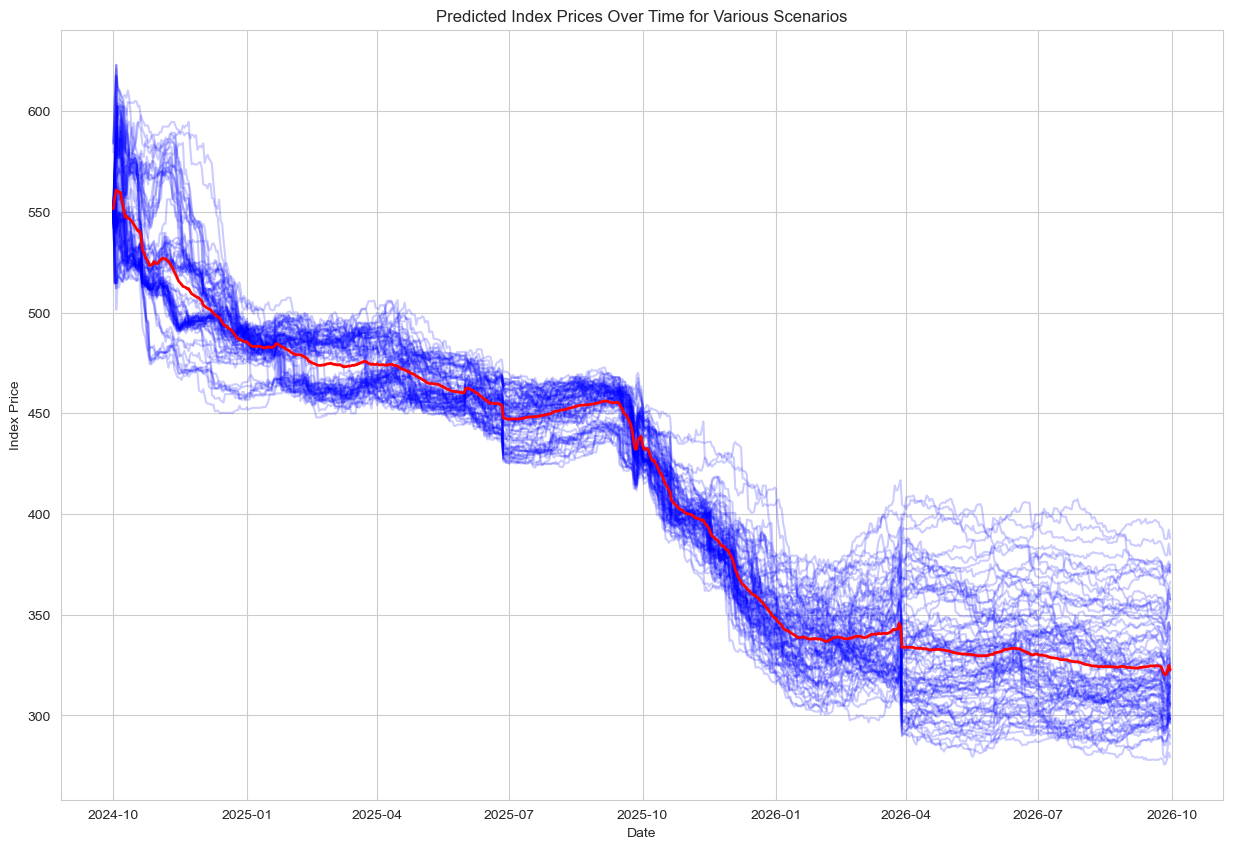

In [135]:
from scipy.stats import zscore

all_predictions_array = np.array(all_predictions)

# for z-score, igonre nan values

z_scores = np.abs(zscore(all_predictions_array, axis=0, nan_policy='omit'))

# Filter out extreme values where Z-score > threshold (here: 2 standard deviations)
threshold = 3
filtered_indices = np.where((z_scores < threshold).all(axis=1))[0]
filtered_predictions = all_predictions_array[filtered_indices]


average_prediction = np.mean(filtered_predictions, axis=0)

plt.figure(figsize=(15, 10))

for scenario_index in filtered_indices:
    plt.plot(X.index, all_predictions[scenario_index], label=f'Scenario {scenario_index + 1}', alpha=0.2, color='blue')

plt.plot(X.index, average_prediction, label='Average Prediction', color='red', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Index Price')
# plt.ylim(-1000, 100)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
# plt.legend()
plt.show()

# Predict the index itself based on synthetic traces

In [21]:
merged_df['Date'] = pd.to_datetime(merged_df['Date'])
merged_df['water_year'] = merged_df['Date'].apply(lambda x: x.year if x.month < 10 else x.year + 1)
merged_df.fillna(merged_df.mean(), inplace=True)
# merged_df
X = merged_df.drop(columns=['Date', 'NQH2O', '6_Month_Forward_Avg'])
y = merged_df['NQH2O']
non_numeric_columns = X.select_dtypes(['object', 'datetime']).columns
X = X.drop(columns=non_numeric_columns)
X = remove_duplicate_columns(X)

corr_matrix = X.corr().abs()
# Select upper triangle of the correlation matrix to keep the first occurrence of highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]   # corr threshold = 0.7
print(f"Number of columns to drop: {len(to_drop)}")
X = X.drop(columns=to_drop)

# feature_columns = X.columns.tolist()
# # joblib.dump(feature_columns, 'feature_columns.pkl') # save feature columns for prediction later

X_train_val, X_test, y_train_val, y_test, train_date, test_date = train_test_split(X, y, merged_df[['Date', 'NQH2O']], test_size=0.2, random_state=42)
train_date, train_nqh2o = train_date['Date'], train_date['NQH2O']
test_date, test_nqh2o = test_date['Date'], test_date['NQH2O']
X.shape

Duplicate columns found: ['socal_tableA_delivery', 'socal_tableA_recharged', 'socal_tableA_projected', 'socal_cvpdelta_dynamic_recharge_cap', 'socal_exchange_dynamic_recharge_cap', 'socal_cvc_dynamic_recharge_cap', 'socal_friant1_dynamic_recharge_cap', 'socal_friant2_dynamic_recharge_cap', 'socal_kaweah_dynamic_recharge_cap', 'socal_tule_dynamic_recharge_cap', 'socal_kern_dynamic_recharge_cap', 'socal_kings_dynamic_recharge_cap', 'socal_IVR_recharged', 'socal_RRB_recharged', 'socal_dynamic_recovery_cap', 'socal_irr_demand', 'socal_tot_demand', 'socal_kern_flood_irrigation', 'socal_tableA_paper', 'socal_exchanged_SW', 'socal_tableA_dynamic_recharge_cap', 'socal_pumping', 'socal_tableA_turnback', 'socal_tableA_carryover', 'centralcoast_tableA_projected', 'centralcoast_cvpdelta_dynamic_recharge_cap', 'centralcoast_exchange_dynamic_recharge_cap', 'centralcoast_cvc_dynamic_recharge_cap', 'centralcoast_friant1_dynamic_recharge_cap', 'centralcoast_friant2_dynamic_recharge_cap', 'centralcoast_

(606, 504)

In [22]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    # ('pca', PCA(n_components=5)),  # Adjust n_components based on your dataset
    ('rf', RandomForestRegressor(random_state=42))
])

param_grid = {
    'rf__n_estimators': [100, 50, 200],  # Number of trees in the forest
    'rf__max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'rf__max_depth': [10, 20],  # Maximum depth of the tree
    'rf__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'rf__min_samples_leaf': [2, 4]  # Minimum number of samples required to be at a leaf node
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='r2')
grid_search.fit(X_train_val, y_train_val)

best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f'Best params: {best_params}')
y_pred_test = best_pipeline.predict(X_test)

r2_test = r2_score(y_test, y_pred_test)
print(f'R² score on the test set with optimized RandomForestRegressor: {r2_test:.2f}')

feature_importances = best_pipeline.named_steps['rf'].feature_importances_

coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})

coefficients['Rank'] = coefficients['Importance'].rank(ascending=False)
coefficients.sort_values(by='Rank')

# Save the best pipeline
joblib.dump(best_pipeline, 'NQH2O_random_forest_pipeline_with_pca.pkl')

Best params: {'rf__max_depth': 20, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
R² score on the test set with optimized RandomForestRegressor: 0.98


['NQH2O_random_forest_pipeline_with_pca.pkl']

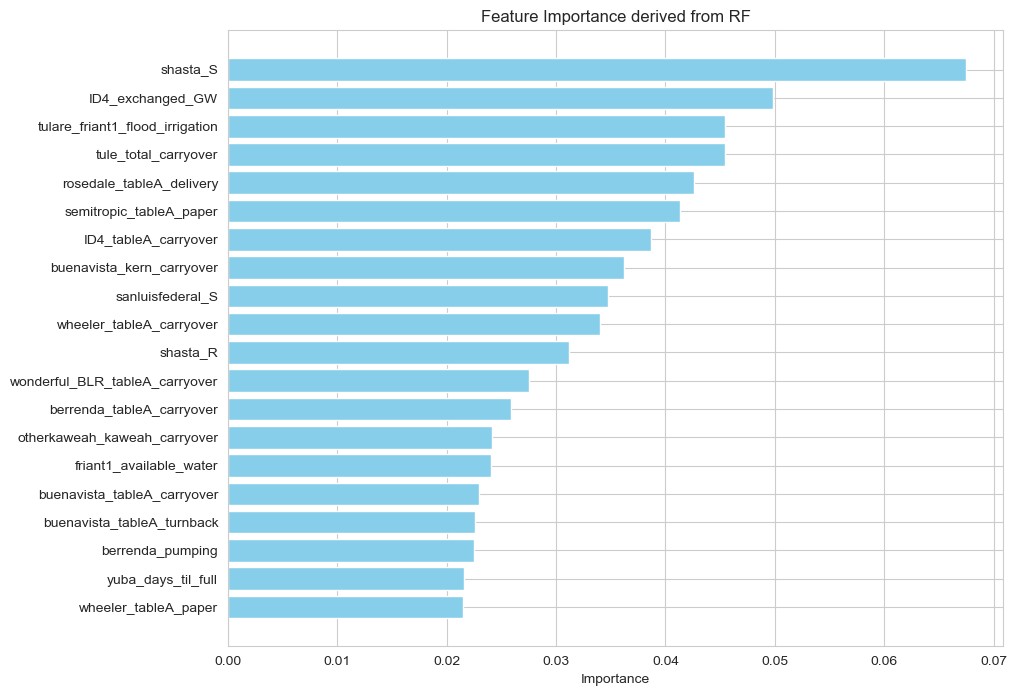

In [23]:
coefficients = pd.DataFrame({
    'features': X.columns.tolist(),
    'Importance': feature_importances
})
coefficients = coefficients.sort_values(by='Importance', ascending=False)
coefficients['Rank'] = range(1, len(coefficients) + 1)
plt.figure(figsize=(10, 8))
plt.barh(coefficients.head(20)['features'], coefficients.head(20)['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance derived from RF')
plt.gca().invert_yaxis()  # To have the highest rank at the top
plt.show()

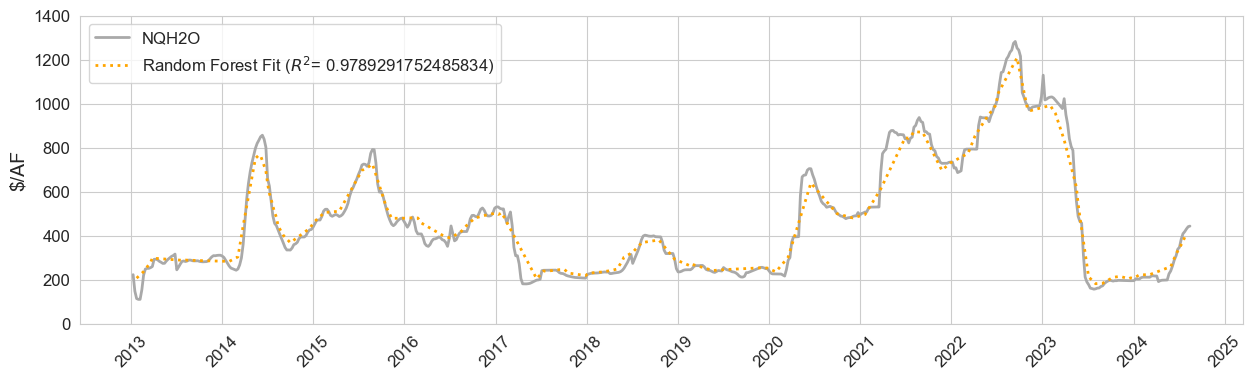

In [24]:
test_results = pd.DataFrame({
    'date': test_date, 
    'actual': y_test,
    'NQH2O': test_nqh2o,
    'predicted_rf': y_pred_test
})
# Sort the DataFrame by date
test_results = test_results.sort_values(by='date')

plt.figure(figsize=(15, 4))

# plt.plot(merged_df['Date'], merged_df['6_Month_Forward_Avg'], label='NQH2O$_{6}$', linestyle='--', color='green', linewidth=2)
plt.plot(merged_df['Date'], merged_df['NQH2O'], label='NQH2O', linestyle='-', color='darkgrey', linewidth=2)
plt.plot(test_results['date'], test_results['predicted_rf'], label=f'Random Forest Fit ($R^{{2}}$= {r2_test})', linestyle=':', color='orange', linewidth=2)

# Labels, Title, and Formatting
plt.ylabel('$/AF', fontsize=14)
plt.ylim(0, 1400)
# plt.title('Actual and Predicted 6-Month Forward Averages (based on CALFEWS Output)', fontsize=16)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.show()

In [27]:
random_forest_pipeline_with_pca = joblib.load('random_forest_pipeline_with_pca.pkl')
# pca = joblib.load('pca_model.pkl')

output_folder = 'results/'

plt.figure(figsize=(15, 10))
all_predictions = []
all_indices = []
for scenario_number in range(1, 101):
    scenario_folder = os.path.join(output_folder, str(scenario_number))
    output_file = os.path.join(scenario_folder, 'results.hdf5')
    hydro_data = get_results_sensitivity_number_outside_model(output_file, '')

    # Calculate rolling mean
    window_size = '180D'
    X = hydro_data.rolling(window=window_size, center=False).mean()
    X['water_year'] = X.index.map(lambda x: x.year if x.month < 10 else x.year + 1)

    # Ensure feature columns match
    # X_top_20 = ensure_columns_match(X, top_features)
    # predicted_index_price = lasso_pipeline.predict(X_top_20)
    X_matched = ensure_columns_match(X, feature_columns)
    # X_pca = pca.transform(X_matched)
    predicted_index_price = random_forest_pipeline_with_pca.predict(X_matched)
    
    all_predictions.append(predicted_index_price)
    all_indices.append(X.index)

<Figure size 1500x1000 with 0 Axes>

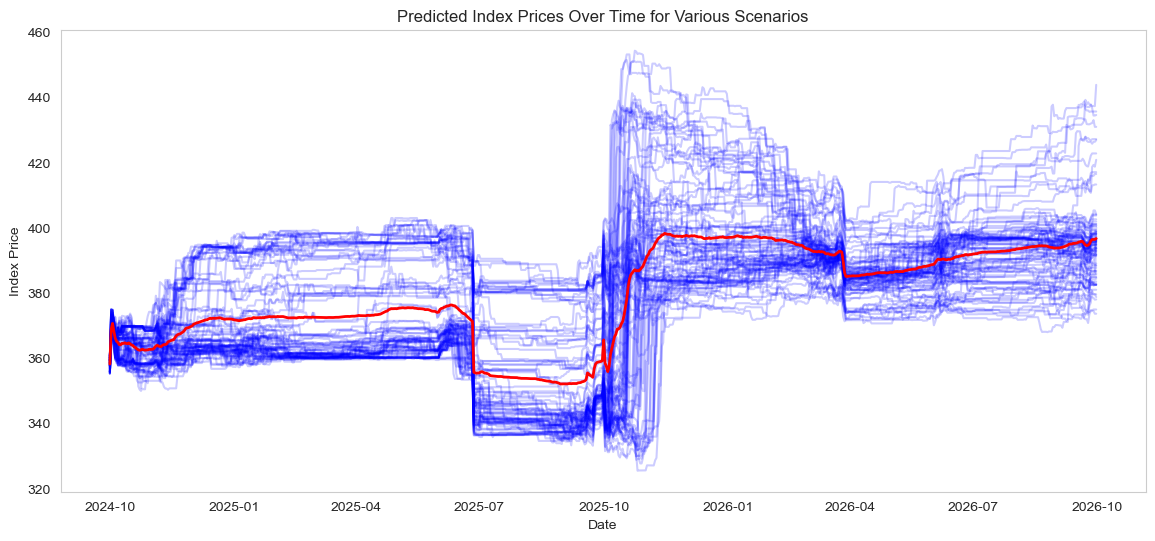

In [32]:
from scipy.stats import zscore
all_predictions_array = np.array(all_predictions)
z_scores = np.abs(zscore(all_predictions_array, axis=0, nan_policy='omit'))

# Filter out extreme values where Z-score > threshold (here: 23 standard deviations)
threshold = 3
filtered_indices = np.where((z_scores < threshold).all(axis=1))[0]
filtered_predictions = all_predictions_array[filtered_indices]
average_prediction = np.mean(filtered_predictions, axis=0)

plt.figure(figsize=(14, 6))

for scenario_index in filtered_indices:
    plt.plot(X.index, all_predictions[scenario_index], label=f'Scenario {scenario_index + 1}', alpha=0.2, color='blue')

plt.plot(X.index, average_prediction, label='Average Prediction', color='red', linewidth=2)

# Finalize the main plot
plt.xlabel('Date')
plt.ylabel('Index Price')
plt.grid(False)
# plt.ylim(-2000, 1000)
plt.title('Predicted Index Prices Over Time for Various Scenarios')
plt.show()